In [1]:
import numpy as np

from aiida import load_profile
from aiida.orm import *

from qe_tools import CONSTANTS as C

from ase.io import write, read
from ase import units
from ase.calculators.singlepoint import SinglePointCalculator

from flare.atoms import FLARE_Atoms
from flare.learners.utils import is_std_in_bound, get_env_indices
from flare.bffs.sgp.calculator import SGP_Calculator
from flare.bffs.sgp._C_flare import Structure

import matplotlib.pyplot as plt

load_profile()


plt.rcParams.update({
    'text.usetex': False,
    # 'text.latex.preamble': r'\usepackage{sansmath} \sansmath',
    'pdf.fonttype':42,
    'font.family':'sans-serif',
    'font.sans-serif':'Arial',
    'font.size':14,
    'mathtext.fontset': 'stixsans',
})

In [2]:
!export OMP_NUM_THREADS=1

## Evaluate a model

In [3]:
flare_calc, _ = SGP_Calculator.from_file('./model.json')

atoms_test  = read("./dataset-sscha.xyz", index=':')
atoms_flare = [FLARE_Atoms.from_ase_atoms(atoms) for atoms in atoms_test]

for atoms in atoms_flare:
    atoms.calc = flare_calc

print(f"Number of frames in the set: {len(atoms_test)}")

Number of frames in the set: 91


In [4]:
atoms_flare[0].get_stress(voigt=False)
at_fl = atoms_flare[0]
at_fl.stress

array([-0.01628743, -0.0065395 , -0.00436347,  0.01573904, -0.00761871,
       -0.01507365])

In [5]:
at = atoms_test[0]
at.calc = flare_calc
at.get_stress(voigt=False)
# at

array([[-0.01628743, -0.01507365, -0.00761871],
       [-0.01507365, -0.0065395 ,  0.01573904],
       [-0.00761871,  0.01573904, -0.00436347]])

In [6]:
ref_energy = np.array([atoms.get_potential_energy() for atoms in atoms_test])
ref_forces = np.array([atoms.get_forces() for atoms in atoms_test])
ref_stress = np.array([atoms.get_stress() for atoms in atoms_test])

model_energy = np.array([atoms.get_potential_energy() for atoms in atoms_flare])
model_forces = np.array([atoms.get_forces() for atoms in atoms_flare])
model_stress = np.array([atoms.get_stress() for atoms in atoms_flare])

mae_energy = np.abs(ref_energy-model_energy).mean()
mae_forces = np.abs(ref_forces-model_forces).mean()
mae_stress = np.abs(ref_stress-model_stress).mean()

print(f'MAE energy: {mae_energy:.4f} eV')
print(f'MAE forces: {mae_forces:.4f} eV ang-1')
print(f'MAE stress: {mae_stress:.4f} eV ang-3')

MAE energy: 0.3489 eV
MAE forces: 0.1379 eV ang-1
MAE stress: 0.0021 eV ang-3


In [7]:
index = 0
model_stress[index], ref_stress[index]
# model_forces[index]-ref_forces[index]

(array([-0.01628743, -0.0065395 , -0.00436347,  0.01573904, -0.00761871,
        -0.01507365]),
 array([-0.01628743, -0.0065395 , -0.00436347,  0.01573904, -0.00761871,
        -0.01507365]))

## Plot statistics

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


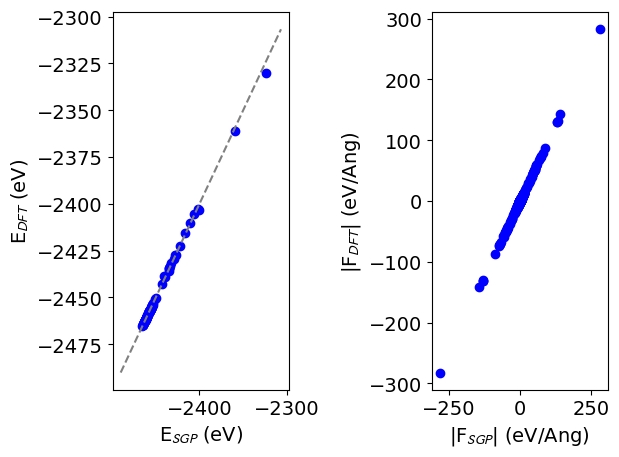

In [8]:
fig, axs = plt.subplots(1,2)

# --- Energies
axs[0].plot(model_energy, ref_energy, 'bo')
axs[0].plot([ref_energy.min()*1.01, ref_energy.max()*0.99], [ref_energy.min()*1.01, ref_energy.max()*0.99], ls='--', c='gray')

axs[0].set_xlabel('E$_{SGP}}$ (eV)')
axs[0].set_ylabel('E$_{DFT}$ (eV)')

# --- Forces
axs[1].plot(model_forces.flatten(), ref_forces.flatten(), 'bo')
# axs[1].plot([ref_energy.min()*1.01, ref_energy.max()*0.99], [ref_energy.min()*1.01, ref_energy.max()*0.99], ls='--', c='gray')

axs[1].set_xlabel('|F$_{SGP}}$| (eV/Ang)')
axs[1].set_ylabel('|F$_{DFT}$| (eV/Ang)')

fig.tight_layout()
plt.show()

## Relax using model

In [9]:
from ase.optimize import BFGS
from ase.constraints import ExpCellFilter

vc_relax = False
filepath = './Si.pwi'

atoms = read(filepath)
atoms.calc = flare_calc
print("Initial volume: ", atoms.get_volume())

if vc_relax:
    ecf = ExpCellFilter(atoms, scalar_pressure=0.1) # 0.05 ->  8 GPa
    optimizer = BFGS(ecf)
else:
    optimizer = BFGS(atoms=atoms)

optimizer.run(fmax=0.001)

# print("Final cell")
# print(optimizer.atoms.atoms.cell)

Initial volume:  40.04698463143717
      Step     Time          Energy         fmax
BFGS:    0 09:14:25     -308.491702        0.0000


True

## EOS

In [10]:
scale_factors = np.arange(0.8,1.325,0.025)
atoms = read(filepath)

energies = []
volumes = []
for scale_factor in scale_factors:
    scaled_atoms = atoms.copy()
    scaled_atoms.calc = flare_calc
    scaled_atoms.set_cell(scaled_atoms.get_cell() * scale_factor ** (1 / 3), scale_atoms=True)
    energies.append(scaled_atoms.get_potential_energy())
    volumes.append(scaled_atoms.get_volume())

print("Minimum at: ", volumes[energies.index(min(energies))])

Minimum at:  40.04698463143717


In [11]:
np.savetxt('./e-v.dat', np.array([volumes, energies]).T)

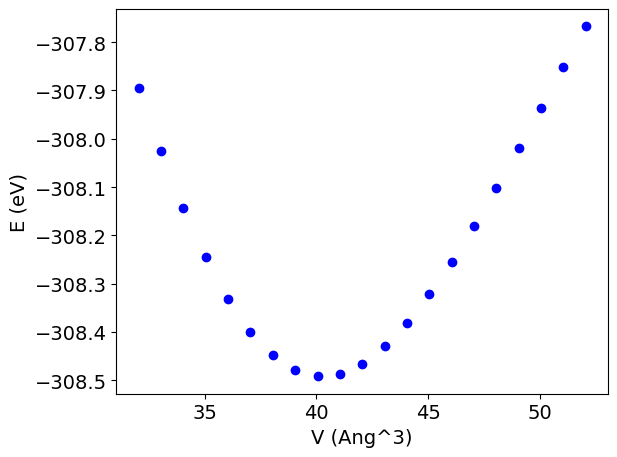

In [12]:
fig, ax = plt.subplots(1,1)

# --- Energies
ax.plot(volumes, energies, 'bo')

ax.set_xlabel('V (Ang^3)')
ax.set_ylabel('E (eV)')

fig.tight_layout()
plt.show()

## Phonons using Phonopy and FLARE

In [13]:
def run_phonons(atoms, filename: str = None):
    """Run phonons using Phonopy."""
    from ase.atoms import Atoms
    from phonopy import Phonopy
    from phonopy.structure.atoms import PhonopyAtoms

    # ================================= INPUTS ======================================= #
    supercell_size = 4
    distance = 0.01 # in Angstrom
    t_max = 300 # Kelvin
    symmetrize = False
    conventional = True
    primitive_matrix = None
    thermal_properties = True
    # primitive_matrix = 'auto'
    # ================================================================================ #

    supercell_matrix = [supercell_size]*3
    if conventional:
        supercell_matrix = np.dot(supercell_size*np.eye(3), -np.array([[1,1,-1],[1,-1,1],[-1,1,1]]) ) # conventional cell

    unitcell = PhonopyAtoms(
        symbols=atoms.get_chemical_symbols(),
        numbers=atoms.get_atomic_numbers(),
        scaled_positions=atoms.get_scaled_positions(),
        cell=atoms.get_cell(),
    )

    ph = Phonopy(
        unitcell=unitcell,
        primitive_matrix=primitive_matrix,
        supercell_matrix=supercell_matrix,
    )

    ph.generate_displacements(distance=distance)
    supercells = ph.get_supercells_with_displacements()

    sets_of_forces = []
    for supercell in supercells:
        cell, scaled_positions, numbers = supercell.totuple()
        supercell_atoms = Atoms(
            cell=cell,
            scaled_positions=scaled_positions,
            numbers=numbers,
            calculator=flare_calc
        )
        sets_of_forces.append(supercell_atoms.get_forces())

    ph.set_forces(sets_of_forces=sets_of_forces)
    ph.produce_force_constants()

    if symmetrize:
        ph.symmetrize_force_constants()
        ph.symmetrize_force_constants_by_space_group()
        
    if thermal_properties:
        ph.run_mesh(mesh=300)
        ph.run_thermal_properties()#t_max=t_max)
        ph.thermal_properties.write_yaml(filename)

In [ ]:
start_index = -energies.index(min(energies))
for scale_factor in scale_factors:
    scaled_atoms = atoms.copy()
    scaled_atoms.calc = flare_calc
    scaled_atoms.set_cell(scaled_atoms.get_cell() * scale_factor ** (1 / 3), scale_atoms=True)
    run_phonons(scaled_atoms, filename=f'./thermal_properties.yaml-{start_index}')
    start_index += 1

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

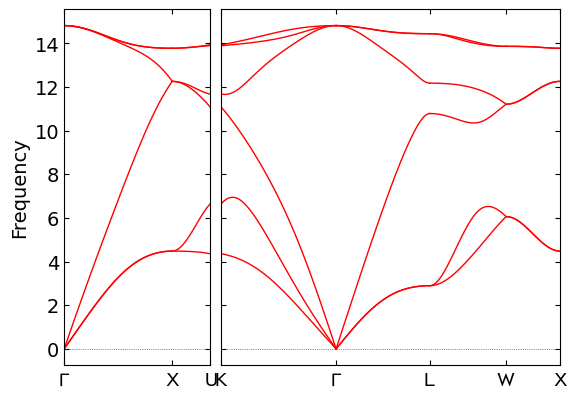

In [16]:
def run_phonons(atoms, filename: str = None):
    """Run phonons using Phonopy."""
    from ase.atoms import Atoms
    from phonopy import Phonopy
    from phonopy.structure.atoms import PhonopyAtoms

    # ================================= INPUTS ======================================= #
    supercell_size = 4
    distance = 0.01 # in Angstrom
    symmetrize = False
    conventional = True
    primitive_matrix = None
    # primitive_matrix = 'auto'
    # ================================================================================ #

    supercell_matrix = [supercell_size]*3
    if conventional:
        supercell_matrix = np.dot(supercell_size*np.eye(3), -np.array([[1,1,-1],[1,-1,1],[-1,1,1]]) ) # conventional cell

    unitcell = PhonopyAtoms(
        symbols=atoms.get_chemical_symbols(),
        numbers=atoms.get_atomic_numbers(),
        scaled_positions=atoms.get_scaled_positions(),
        cell=atoms.get_cell(),
    )

    ph = Phonopy(
        unitcell=unitcell,
        primitive_matrix=primitive_matrix,
        supercell_matrix=supercell_matrix,
    )

    ph.generate_displacements(distance=distance)
    supercells = ph.get_supercells_with_displacements()

    sets_of_forces = []
    for supercell in supercells:
        cell, scaled_positions, numbers = supercell.totuple()
        supercell_atoms = Atoms(
            cell=cell,
            scaled_positions=scaled_positions,
            numbers=numbers,
            calculator=flare_calc
        )
        sets_of_forces.append(supercell_atoms.get_forces())

    ph.set_forces(sets_of_forces=sets_of_forces)
    ph.produce_force_constants()
    return ph

scaled_atoms = atoms.copy()
ph = run_phonons(atoms)
ph.auto_band_structure(plot=True)